# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

In [1]:
!nvidia-smi

Mon Apr  4 13:57:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:65:00.0 Off |                  N/A |
| 35%   31C    P0    67W / 280W |      0MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:B3:00.0 Off |                  N/A |
| 26%   28C    P0    32W / 280W |      0MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

# Download and import required packages

In [2]:
# !pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
# !pip install --upgrade jupyter ipywidgets

In [3]:
# !git clone https://github.com/pytorch/fairseq.git
# !cd fairseq && git checkout 9a1c497
# !pip install --upgrade ./fairseq/

In [4]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [5]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed) 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

## Dataset Download

In [6]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted2020.tgz",
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/test.tgz",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

# prefix.mkdir(parents=True, exist_ok=True)
# for u, f in zip(urls, file_names):
#     path = prefix/f
#     if not path.exists():
#         !wget {u} -O {path}
#     if path.suffix == ".tgz":
#         !tar -xvf {path} -C {prefix}
#     elif path.suffix == ".zip":
#         !unzip -o {path} -d {prefix}
# !mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
# !mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
# !mv {prefix/'test/test.en'} {prefix/'test.raw.en'}
# !mv {prefix/'test/test.zh'} {prefix/'test.raw.zh'}
# !rm -rf {prefix/'test'}

## Language

In [7]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [8]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## Preprocess files

In [9]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [10]:
# clean_corpus(data_prefix, src_lang, tgt_lang)
# clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

In [11]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## Split into train/valid

In [12]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [13]:
# if (prefix/f'train.clean.{src_lang}').exists() \
# and (prefix/f'train.clean.{tgt_lang}').exists() \
# and (prefix/f'valid.clean.{src_lang}').exists() \
# and (prefix/f'valid.clean.{tgt_lang}').exists():
#     print(f'train/valid splits exists. skipping split.')
# else:
#     line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
#     labels = list(range(line_num))
#     random.shuffle(labels)
#     for lang in [src_lang, tgt_lang]:
#         train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
#         valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
#         count = 0
#         for line in open(f'{data_prefix}.clean.{lang}', 'r'):
#             if labels[count]/line_num < train_ratio:
#                 train_f.write(line)
#             else:
#                 valid_f.write(line)
#             count += 1
#         train_f.close()
#         valid_f.close()

## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [14]:
# import sentencepiece as spm
# vocab_size = 8000
# if (prefix/f'spm{vocab_size}.model').exists():
#     print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
# else:
#     spm.SentencePieceTrainer.train(
#         input=','.join([f'{prefix}/train.clean.{src_lang}',
#                         f'{prefix}/valid.clean.{src_lang}',
#                         f'{prefix}/train.clean.{tgt_lang}',
#                         f'{prefix}/valid.clean.{tgt_lang}']),
#         model_prefix=prefix/f'spm{vocab_size}',
#         vocab_size=vocab_size,
#         character_coverage=1,
#         model_type='unigram', # 'bpe' works as well
#         input_sentence_size=1e6,
#         shuffle_input_sentence=True,
#         normalization_rule_name='nmt_nfkc_cf',
#     )

In [15]:
# spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
# in_tag = {
#     'train': 'train.clean',
#     'valid': 'valid.clean',
#     'test': 'test.raw.clean',
# }
# for split in ['train', 'valid', 'test']:
#     for lang in [src_lang, tgt_lang]:
#         out_path = prefix/f'{split}.{lang}'
#         if out_path.exists():
#             print(f"{out_path} exists. skipping spm_encode.")
#         else:
#             with open(prefix/f'{split}.{lang}', 'w') as out_f:
#                 with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
#                     for line in in_f:
#                         line = line.strip()
#                         tok = spm_model.encode(line, out_type=str)
#                         print(' '.join(tok), file=out_f)

In [16]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁truly ▁a ▁great ▁honor ▁to ▁have ▁the ▁opportunity ▁to ▁come ▁to ▁this ▁stage ▁twice ▁; ▁i ' m ▁extreme ly ▁grateful ▁.
▁i ▁have ▁been ▁blow n ▁away ▁by ▁this ▁conference ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁nice ▁comment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁position ▁.
▁非常謝謝 你 ▁, ▁克里斯 ▁。 ▁能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真是 一大 榮幸 ▁。 ▁我 非常 感激 ▁。
▁這個 研 討 會 給我 留下 了 極為 深刻 的 印象 ▁, ▁我想 感謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼說 ▁, ▁有 部份 原因 是因為我 真的 有 需要 ▁!
▁請 你們 設 身處 地 為我 想一想 ▁!


## Binarize the data with fairseq

In [17]:
# binpath = Path('./DATA/data-bin', dataset_name)
# if binpath.exists():
#     print(binpath, "exists, will not overwrite!")
# else:
#     !python -m fairseq_cli.preprocess \
#         --source-lang {src_lang}\
#         --target-lang {tgt_lang}\
#         --trainpref {prefix/'train'}\
#         --validpref {prefix/'valid'}\
#         --testpref {prefix/'test'}\
#         --destdir {binpath}\
#         --joined-dictionary\
#         --workers 10

# Configuration for experiments

In [18]:
#! config
config = Namespace(
    datadir = "DATA/data-bin/ted2020_with_mono",
    savedir = "./checkpoints/transformer-bt-big",
    run_train = True,
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=10,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2,
    lr_warmup=10000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=60,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=True,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [19]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "ml-hw5"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

2022-04-04 13:58:03 | ERROR | wandb.jupyter | Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: tedli (use `wandb login --relogin` to force relogin)


# CUDA Environments

In [20]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2022-04-04 13:58:08 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2022-04-04 13:58:08 | INFO | fairseq.utils | rank   0: capabilities =  7.5  ; total memory = 23.653 GB ; name = TITAN RTX                               
2022-04-04 13:58:08 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [21]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask
# from fairseq.tasks import translation
## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-04-04 13:58:08 | INFO | fairseq.tasks.translation | [en] dictionary: 15992 types
2022-04-04 13:58:08 | INFO | fairseq.tasks.translation | [zh] dictionary: 15992 types


In [22]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-04-04 13:58:08 | INFO | ml-hw5 | loading data for epoch 1
2022-04-04 13:58:08 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: DATA/data-bin/ted2020_with_mono/train.zh-en.en
2022-04-04 13:58:08 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: DATA/data-bin/ted2020_with_mono/train.zh-en.zh
2022-04-04 13:58:08 | INFO | fairseq.tasks.translation | DATA/data-bin/ted2020_with_mono train en-zh 390041 examples
2022-04-04 13:58:08 | INFO | fairseq.data.data_utils | loaded 780,952 examples from: DATA/data-bin/ted2020_with_mono/train1.en-zh.en
2022-04-04 13:58:08 | INFO | fairseq.data.data_utils | loaded 780,952 examples from: DATA/data-bin/ted2020_with_mono/train1.en-zh.zh
2022-04-04 13:58:08 | INFO | fairseq.tasks.translation | DATA/data-bin/ted2020_with_mono train1 en-zh 780952 examples
2022-04-04 13:58:08 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: DATA/data-bin/ted2020_with_mono/valid.zh-en.en
2022-04-04 13:58:08 | INFO | fairseq.data.

In [23]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  16,   13,    8, 1423,   44,   18,   62,    6,  510,   23, 1320, 1030,
        1217,    5,    2]),
 'target': tensor([ 128, 3920, 6217, 3166,  323,  388,  444, 9526, 3855,    2])}
"Source: that's exactly what i do optical mind control ."
'Target: 這實在就是我所做的--光學操控思想'


# Dataset iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```



In [24]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=10, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2022-04-04 13:58:08 | WARNING | fairseq.tasks.fairseq_task | 2,079 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[29, 1025, 2524, 682, 935, 1789, 2064, 2490, 3865, 222]


{'id': tensor([2640]),
 'nsentences': 1,
 'ntokens': 6,
 'net_input': {'src_tokens': tensor([[  1,   1,   1,   1,   1,   7, 526,  22,  30,  94,  62,  20,  62,  19,
            27,   2]]),
  'src_lengths': tensor([11]),
  'prev_output_tokens': tensor([[    2,  6898,    30,    63, 11204,    27,     1,     1]])},
 'target': tensor([[ 6898,    30,    63, 11204,    27,     2,     1,     1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [25]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

# Encoder

- The Encoder is a RNN or Transformer Encoder. The following description is for RNN. For every input token, Encoder will generate a output vector and a hidden states vector, and the hidden states vector is passed on to the next step. In other words, the Encoder sequentially reads in the input sequence, and outputs a single vector at each timestep, then finally outputs the final hidden states, or content vector, at the last timestep.
- Parameters:
  - *args*
      - encoder_embed_dim: the dimension of embeddings, this compresses the one-hot vector into fixed dimensions, which achieves dimension reduction
      - encoder_ffn_embed_dim is the dimension of hidden states and output vectors
      - encoder_layers is the number of layers for Encoder RNN
      - dropout determines the probability of a neuron's activation being set to 0, in order to prevent overfitting. Generally this is applied in training, and removed in testing.
  - *dictionary*: the dictionary provided by fairseq. it's used to obtain the padding index, and in turn the encoder padding mask. 
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)

- Inputs: 
    - *src_tokens*: integer sequence representing english e.g. 1, 28, 29, 205, 2 
- Outputs: 
    - *outputs*: the output of RNN at each timestep, can be furthur processed by Attention
    - *final_hiddens*: the hidden states of each timestep, will be passed to decoder for decoding
    - *encoder_padding_mask*: this tells the decoder which position to ignore


In [26]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # pass thru bidirectional RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # Since Encoder is bidirectional, we need to concatenate the hidden states of two directions
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- When the input sequence is long, "content vector" alone cannot accurately represent the whole sequence, attention mechanism can provide the Decoder more information.
- According to the **Decoder embeddings** of the current timestep, match the **Encoder outputs** with decoder embeddings to determine correlation, and then sum the Encoder outputs weighted by the correlation as the input to **Decoder** RNN.
- Common attention implementations use neural network / dot product as the correlation between **query** (decoder embeddings) and **key** (Encoder outputs), followed by **softmax**  to obtain a distribution, and finally **values** (Encoder outputs) is **weighted sum**-ed by said distribution.

- Parameters:
  - *input_embed_dim*: dimensionality of key, should be that of the vector in decoder to attend others
  - *source_embed_dim*: dimensionality of query, should be that of the vector to be attended to (encoder outputs)
  - *output_embed_dim*: dimensionality of value, should be that of the vector after attention, expected by the next layer

- Inputs: 
    - *inputs*: is the key, the vector to attend to others
    - *encoder_outputs*:  is the query/value, the vector to be attended to
    - *encoder_padding_mask*: this tells the decoder which position to ignore
- Outputs: 
    - *output*: the context vector after attention
    - *attention score*: the attention distribution


In [27]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

# Decoder

* The hidden states of **Decoder** will be initialized by the final hidden states of **Encoder** (the content vector)
* At the same time, **Decoder** will change its hidden states based on the input of the current timestep (the outputs of previous timesteps), and generates an output
* Attention improves the performance
* The seq2seq steps are implemented in decoder, so that later the Seq2Seq class can accept RNN and Transformer, without furthur modification.
- Parameters:
  - *args*
      - decoder_embed_dim: is the dimensionality of the decoder embeddings, similar to encoder_embed_dim，
      - decoder_ffn_embed_dim: is the dimensionality of the decoder RNN hidden states, similar to encoder_ffn_embed_dim
      - decoder_layers: number of layers of RNN decoder
      - share_decoder_input_output_embed: usually, the projection matrix of the decoder will share weights with the decoder input embeddings
  - *dictionary*: the dictionary provided by fairseq
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)
- Inputs: 
    - *prev_output_tokens*: integer sequence representing the right-shifted target e.g. 1, 28, 29, 205, 2 
    - *encoder_out*: encoder's output.
    - *incremental_state*: in order to speed up decoding during test time, we will save the hidden state of each timestep. see forward() for details.
- Outputs: 
    - *outputs*: the logits (before softmax) output of decoder for each timesteps
    - *extra*: unsused

In [28]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # extract the outputs from encoder
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # if the information from last timestep is retained, we can continue from there instead of starting from bos
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # incremental state does not exist, either this is training time, or the first timestep of test time
            # prepare for seq2seq: pass the encoder_hidden to the decoder hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # pass thru unidirectional RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # project to embedding size (if hidden differs from embed size, and share_embedding is True, 
        # we need to do an extra projection)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # project to vocab size
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # if incremental, record the hidden states of current timestep, which will be restored in the next timestep
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [29]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [30]:
# # HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    # encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
    # decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [31]:
arch_args = Namespace(
    encoder_embed_dim=1024,
    encoder_ffn_embed_dim=4096,
    encoder_layers=6,
    decoder_embed_dim=1024,
    decoder_ffn_embed_dim=4096,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=512
    args.max_target_positions=512
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [32]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [33]:
model = build_model(arch_args, task)
logger.info(model)

2022-04-04 13:58:14 | INFO | ml-hw5 | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(15992, 1024, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [34]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [35]:
def get_rate(d_model, step_num, warmup_step):
    lr = d_model **(-.5) * min(step_num ** (-.5), step_num * warmup_step ** (-1.5))
    return lr

In [36]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## Scheduling Visualized

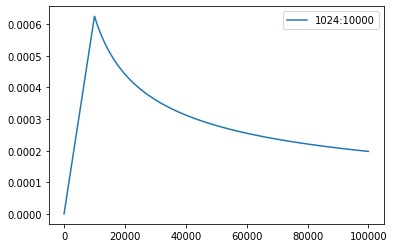

In [37]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])

# Training Procedure

## Training

In [38]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def batch_cosine_similarity(a:torch.tensor, b: torch.tensor, eps=1e-6):
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.clamp(a_n, min=eps)
    b_norm = b / torch.clamp(b_n, min=eps)
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt


def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
    pos_emb = model.decoder.embed_positions.weights.cpu().detach()
    if config.use_wandb:
        wandb.log({"decoder_positional_embedding": wandb.Image(batch_cosine_similarity(pos_emb, pos_emb))})

    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [39]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [40]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights


In [41]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [42]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [43]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-04-04 13:58:18 | INFO | ml-hw5 | task: TranslationTask
2022-04-04 13:58:18 | INFO | ml-hw5 | encoder: TransformerEncoder
2022-04-04 13:58:18 | INFO | ml-hw5 | decoder: TransformerDecoder
2022-04-04 13:58:18 | INFO | ml-hw5 | criterion: LabelSmoothedCrossEntropyCriterion
2022-04-04 13:58:18 | INFO | ml-hw5 | optimizer: NoamOpt
2022-04-04 13:58:18 | INFO | ml-hw5 | num. model params: 209,113,088 (num. trained: 209,113,088)
2022-04-04 13:58:18 | INFO | ml-hw5 | max tokens per batch = 8192, accumulate steps = 2


In [44]:
if config.run_train:
    epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
    try_load_checkpoint(model, optimizer, name=config.resume)
    while epoch_itr.next_epoch_idx <= config.max_epoch:
        # train for one epoch
        train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
        stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
        logger.info("end of epoch {}".format(epoch_itr.epoch))    
        epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-04-04 13:58:18 | INFO | ml-hw5 | no checkpoints found at checkpoints/transformer-bt-big/checkpoint_last.pt!


2022-04-04 14:17:23 | INFO | ml-hw5 | training loss: 7.1104
2022-04-04 14:17:23 | INFO | ml-hw5 | begin validation


2022-04-04 14:18:06 | INFO | ml-hw5 | example source: and making buildings for this beauty makes cities better places to live .
2022-04-04 14:18:06 | INFO | ml-hw5 | example hypothesis: 提供這個城市的物種 。
2022-04-04 14:18:06 | INFO | ml-hw5 | example reference: 為了這種美麗來打造建築物 , 能讓城市成為更棒的居住地 。
2022-04-04 14:18:06 | INFO | ml-hw5 | validation loss:	5.9811
2022-04-04 14:18:06 | INFO | ml-hw5 | BLEU = 6.34 34.0/12.5/4.7/2.0 (BP = 0.801 ratio = 0.819 hyp_len = 91552 ref_len = 111811)
2022-04-04 14:18:08 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint1.pt
2022-04-04 14:18:09 | INFO | ml-hw5 | end of epoch 1


2022-04-04 14:37:14 | INFO | ml-hw5 | training loss: 5.1218
2022-04-04 14:37:14 | INFO | ml-hw5 | begin validation


2022-04-04 14:37:56 | INFO | ml-hw5 | example source: and there's no adaption .
2022-04-04 14:37:56 | INFO | ml-hw5 | example hypothesis: 而且沒有適應力 。
2022-04-04 14:37:56 | INFO | ml-hw5 | example reference: 他們絲毫沒有適應的機會 。
2022-04-04 14:37:56 | INFO | ml-hw5 | validation loss:	4.5871
2022-04-04 14:37:56 | INFO | ml-hw5 | BLEU = 18.94 51.1/26.3/14.1/8.1 (BP = 0.958 ratio = 0.959 hyp_len = 107185 ref_len = 111811)
2022-04-04 14:38:01 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint2.pt
2022-04-04 14:38:06 | INFO | ml-hw5 | end of epoch 2


2022-04-04 14:57:09 | INFO | ml-hw5 | training loss: 4.1575
2022-04-04 14:57:09 | INFO | ml-hw5 | begin validation


2022-04-04 14:57:47 | INFO | ml-hw5 | example source: then another thing .
2022-04-04 14:57:47 | INFO | ml-hw5 | example hypothesis: 然後另一件事
2022-04-04 14:57:47 | INFO | ml-hw5 | example reference: 另外一件事 。
2022-04-04 14:57:47 | INFO | ml-hw5 | validation loss:	4.1411
2022-04-04 14:57:47 | INFO | ml-hw5 | BLEU = 21.58 58.5/32.2/18.5/11.2 (BP = 0.863 ratio = 0.871 hyp_len = 97426 ref_len = 111811)
2022-04-04 14:57:52 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint3.pt
2022-04-04 14:57:58 | INFO | ml-hw5 | end of epoch 3


2022-04-04 15:16:55 | INFO | ml-hw5 | training loss: 3.7880
2022-04-04 15:16:55 | INFO | ml-hw5 | begin validation


2022-04-04 15:17:35 | INFO | ml-hw5 | example source: google answers is something we started , which is really cool , which lets you for five to 100 dollars , you can type a question in , and then there's a pool of researchers that go out and research it for you , and it's guaranteed and all that , and you can get actually very good answers to things without spending all that time yourself .
2022-04-04 15:17:35 | INFO | ml-hw5 | example hypothesis: 谷歌的答案是我們開始的 , 這真的很酷 , 這讓你花了5到100美元 , 你可以輸入一個問題 , 然後有一群研究人員去研究它 , 並保證 , 還有這些 , 還有所有的研究 , 你就可以得到答案 。
2022-04-04 15:17:35 | INFO | ml-hw5 | example reference: googleanswers是一項我們已經開始的項目 , 這真的非常的酷這讓你能花5到100美元輸入一個你想問的問題接著將有一大群的研究人員為你研究這個問題 , 且有品質保證你可以不用花費自己太多的時間就得到很好的答案
2022-04-04 15:17:35 | INFO | ml-hw5 | validation loss:	3.9077
2022-04-04 15:17:35 | INFO | ml-hw5 | BLEU = 24.36 58.2/32.7/19.3/12.0 (BP = 0.945 ratio = 0.947 hyp_len = 105854 ref_len = 111811)
2022-04-04 15:17:40 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw

2022-04-04 15:36:53 | INFO | ml-hw5 | training loss: 3.6035
2022-04-04 15:36:53 | INFO | ml-hw5 | begin validation


2022-04-04 15:37:33 | INFO | ml-hw5 | example source: it may absorb light , but it certainly does not reflect character .
2022-04-04 15:37:33 | INFO | ml-hw5 | example hypothesis: 它可能會吸收光 , 但它肯定不會反映出人格 。
2022-04-04 15:37:33 | INFO | ml-hw5 | example reference: 它可以吸收陽光但它肯定不代表個性翻譯:盧紀睿
2022-04-04 15:37:33 | INFO | ml-hw5 | validation loss:	3.7772
2022-04-04 15:37:33 | INFO | ml-hw5 | BLEU = 25.06 59.0/33.7/20.1/12.6 (BP = 0.940 ratio = 0.942 hyp_len = 105324 ref_len = 111811)
2022-04-04 15:37:39 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint5.pt
2022-04-04 15:37:43 | INFO | ml-hw5 | end of epoch 5


2022-04-04 15:56:52 | INFO | ml-hw5 | training loss: 3.4765
2022-04-04 15:56:52 | INFO | ml-hw5 | begin validation


2022-04-04 15:57:33 | INFO | ml-hw5 | example source: ab: and what month ?
2022-04-04 15:57:33 | INFO | ml-hw5 | example hypothesis: 亞瑟:哪月 ?
2022-04-04 15:57:33 | INFO | ml-hw5 | example reference: 哪月呢 ? chris:六月 。
2022-04-04 15:57:33 | INFO | ml-hw5 | validation loss:	3.6837
2022-04-04 15:57:33 | INFO | ml-hw5 | BLEU = 26.10 58.8/33.8/20.4/13.1 (BP = 0.967 ratio = 0.968 hyp_len = 108188 ref_len = 111811)
2022-04-04 15:57:38 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint6.pt
2022-04-04 15:57:43 | INFO | ml-hw5 | end of epoch 6


2022-04-04 16:16:47 | INFO | ml-hw5 | training loss: 3.3785
2022-04-04 16:16:47 | INFO | ml-hw5 | begin validation


2022-04-04 16:17:27 | INFO | ml-hw5 | example source: i thought they were fun .
2022-04-04 16:17:27 | INFO | ml-hw5 | example hypothesis: 我覺得他們很好玩 。
2022-04-04 16:17:27 | INFO | ml-hw5 | example reference: 但在推特上直播節目的這個想法 ,
2022-04-04 16:17:27 | INFO | ml-hw5 | validation loss:	3.6062
2022-04-04 16:17:27 | INFO | ml-hw5 | BLEU = 26.70 59.7/34.9/21.4/13.8 (BP = 0.953 ratio = 0.954 hyp_len = 106658 ref_len = 111811)
2022-04-04 16:17:32 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint7.pt
2022-04-04 16:17:38 | INFO | ml-hw5 | end of epoch 7


2022-04-04 16:36:43 | INFO | ml-hw5 | training loss: 3.2506
2022-04-04 16:36:43 | INFO | ml-hw5 | begin validation


2022-04-04 16:37:23 | INFO | ml-hw5 | example source: but all that said , we have a lot of heavy lifting to still do ahead of us .
2022-04-04 16:37:23 | INFO | ml-hw5 | example hypothesis: 但這些都說 , 我們還有很多重舉要領先我們 。
2022-04-04 16:37:23 | INFO | ml-hw5 | example reference: 但是 , 儘管這樣 , 我們還有很多重要的事情需要解決 。
2022-04-04 16:37:23 | INFO | ml-hw5 | validation loss:	3.5208
2022-04-04 16:37:23 | INFO | ml-hw5 | BLEU = 27.17 60.7/36.0/22.3/14.6 (BP = 0.936 ratio = 0.938 hyp_len = 104853 ref_len = 111811)
2022-04-04 16:37:28 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint8.pt
2022-04-04 16:37:33 | INFO | ml-hw5 | end of epoch 8


2022-04-04 16:56:40 | INFO | ml-hw5 | training loss: 3.1269
2022-04-04 16:56:40 | INFO | ml-hw5 | begin validation


2022-04-04 16:57:21 | INFO | ml-hw5 | example source: we can't .
2022-04-04 16:57:21 | INFO | ml-hw5 | example hypothesis: 我們不能 。
2022-04-04 16:57:21 | INFO | ml-hw5 | example reference: 這是行不通的 。
2022-04-04 16:57:21 | INFO | ml-hw5 | validation loss:	3.4562
2022-04-04 16:57:21 | INFO | ml-hw5 | BLEU = 28.17 60.0/35.7/22.3/14.7 (BP = 0.973 ratio = 0.973 hyp_len = 108845 ref_len = 111811)
2022-04-04 16:57:26 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint9.pt
2022-04-04 16:57:31 | INFO | ml-hw5 | end of epoch 9


2022-04-04 17:16:39 | INFO | ml-hw5 | training loss: 3.0265
2022-04-04 17:16:39 | INFO | ml-hw5 | begin validation


2022-04-04 17:17:18 | INFO | ml-hw5 | example source: for example , new york passed a law that said that the teacher improvement data could not be made available and used in the tenure decision for the teachers .
2022-04-04 17:17:18 | INFO | ml-hw5 | example hypothesis: 比如 , 紐約通過了一項法律 , 宣稱老師改善資料無法取得 , 且用在終身決策上 。
2022-04-04 17:17:18 | INFO | ml-hw5 | example reference: 例如 , 紐約通過了一項法令:用於提升教學水平的資料不能被拿來做為評估老師的依據 , 決定一位老師是否繼續留任 。
2022-04-04 17:17:18 | INFO | ml-hw5 | validation loss:	3.4174
2022-04-04 17:17:18 | INFO | ml-hw5 | BLEU = 28.35 61.1/36.5/22.9/15.2 (BP = 0.956 ratio = 0.956 hyp_len = 106945 ref_len = 111811)
2022-04-04 17:17:23 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint10.pt
2022-04-04 17:17:28 | INFO | ml-hw5 | end of epoch 10


2022-04-04 17:36:34 | INFO | ml-hw5 | training loss: 2.9415
2022-04-04 17:36:34 | INFO | ml-hw5 | begin validation


2022-04-04 17:37:15 | INFO | ml-hw5 | example source: now , of course , in a mosh pit it's hard to specify a destination .
2022-04-04 17:37:15 | INFO | ml-hw5 | example hypothesis: 當然 , 在摩西的坑洞裡 , 很難確定目的地 。
2022-04-04 17:37:15 | INFO | ml-hw5 | example reference: 當然 , 在魔秀舞池裡很難料定目的地 ,
2022-04-04 17:37:15 | INFO | ml-hw5 | validation loss:	3.3866
2022-04-04 17:37:15 | INFO | ml-hw5 | BLEU = 29.11 60.0/35.9/22.8/15.2 (BP = 0.991 ratio = 0.991 hyp_len = 110810 ref_len = 111811)
2022-04-04 17:37:21 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint11.pt
2022-04-04 17:37:25 | INFO | ml-hw5 | end of epoch 11


2022-04-04 17:56:27 | INFO | ml-hw5 | training loss: 2.8687
2022-04-04 17:56:27 | INFO | ml-hw5 | begin validation


2022-04-04 17:57:07 | INFO | ml-hw5 | example source: it's a kind of an aria , i would say , and in many tapes that i have .
2022-04-04 17:57:07 | INFO | ml-hw5 | example hypothesis: 我會說 , 這是一種詠嘆調 , 在很多我有的錄音帶中 ,
2022-04-04 17:57:07 | INFO | ml-hw5 | example reference: 這有點像是獨白 , 在很多我做的錄音訪談裡都有獨白 。
2022-04-04 17:57:07 | INFO | ml-hw5 | validation loss:	3.3563
2022-04-04 17:57:07 | INFO | ml-hw5 | BLEU = 29.24 60.8/36.7/23.3/15.7 (BP = 0.973 ratio = 0.974 hyp_len = 108853 ref_len = 111811)
2022-04-04 17:57:12 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint12.pt
2022-04-04 17:57:17 | INFO | ml-hw5 | end of epoch 12


2022-04-04 18:16:23 | INFO | ml-hw5 | training loss: 2.8028
2022-04-04 18:16:23 | INFO | ml-hw5 | begin validation


2022-04-04 18:17:02 | INFO | ml-hw5 | example source: intense feelings of imposterism can prevent people from sharing their great ideas or applying for jobs and programs where they’d excel .
2022-04-04 18:17:02 | INFO | ml-hw5 | example hypothesis: 強烈的冒名頂替感 , 可以防止人們分享他們偉大的想法 , 或申請工作和專案 , 讓他們被excel排擠 。
2022-04-04 18:17:02 | INFO | ml-hw5 | example reference: 強烈的冒名頂替感會讓人無法分享他們很棒的點子或無法應徵那些他們明明可以做得很出色的工作或專案 。
2022-04-04 18:17:02 | INFO | ml-hw5 | validation loss:	3.3289
2022-04-04 18:17:02 | INFO | ml-hw5 | BLEU = 29.66 61.3/37.2/23.8/16.1 (BP = 0.970 ratio = 0.971 hyp_len = 108546 ref_len = 111811)
2022-04-04 18:17:08 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint13.pt
2022-04-04 18:17:13 | INFO | ml-hw5 | end of epoch 13


2022-04-04 18:36:18 | INFO | ml-hw5 | training loss: 2.7450
2022-04-04 18:36:18 | INFO | ml-hw5 | begin validation


2022-04-04 18:36:57 | INFO | ml-hw5 | example source: everything from health , nutrition , employment all of these are positively impacted when girls are educated .
2022-04-04 18:36:57 | INFO | ml-hw5 | example hypothesis: 從健康、營養、就業這些都在女孩受教育時正面影響
2022-04-04 18:36:57 | INFO | ml-hw5 | example reference: 從健康、營養、就業當女孩們能接受教育 , 對所有這些都有正面的影響 。
2022-04-04 18:36:57 | INFO | ml-hw5 | validation loss:	3.3153
2022-04-04 18:36:57 | INFO | ml-hw5 | BLEU = 30.13 61.4/37.5/24.2/16.5 (BP = 0.973 ratio = 0.973 hyp_len = 108800 ref_len = 111811)
2022-04-04 18:37:02 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint14.pt
2022-04-04 18:37:07 | INFO | ml-hw5 | end of epoch 14


2022-04-04 18:56:10 | INFO | ml-hw5 | training loss: 2.6943
2022-04-04 18:56:10 | INFO | ml-hw5 | begin validation


2022-04-04 18:56:48 | INFO | ml-hw5 | example source: worse still , it turned out the bridge’s cable contractor had been selling them faulty wires .
2022-04-04 18:56:48 | INFO | ml-hw5 | example hypothesis: 更糟的是 , 這座橋的纜繩承包商賣的是錯誤的電線 。
2022-04-04 18:56:48 | INFO | ml-hw5 | example reference: 更糟糕的是 , 結果發現該橋的纜繩包商一直在賣有問題的纜線給他們 。
2022-04-04 18:56:48 | INFO | ml-hw5 | validation loss:	3.2978
2022-04-04 18:56:48 | INFO | ml-hw5 | BLEU = 29.80 61.8/37.7/24.4/16.6 (BP = 0.957 ratio = 0.958 hyp_len = 107082 ref_len = 111811)
2022-04-04 18:56:53 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint15.pt
2022-04-04 18:56:54 | INFO | ml-hw5 | end of epoch 15


2022-04-04 19:15:55 | INFO | ml-hw5 | training loss: 2.6470
2022-04-04 19:15:55 | INFO | ml-hw5 | begin validation


2022-04-04 19:16:34 | INFO | ml-hw5 | example source: and you see agenda this is marketing , this is politics trying to convince you to have one model versus another , trying to convince you to ignore a model and trust your feelings , marginalizing people with models you don't like .
2022-04-04 19:16:34 | INFO | ml-hw5 | example hypothesis: 你看 , 議程──這是行銷 , 政治試著說服你去有一個模型和另一個模型 , 試圖說服你去忽略一個模型 , 並相信你的感覺 , 用你不喜歡的模型邊緣化人群 。
2022-04-04 19:16:34 | INFO | ml-hw5 | example reference: 這個規畫表是一種行銷 , 也是政治它企圖影響你信任某種模型而放棄另一個企圖影響去忽視模型只信任你的感覺並且邊緣化那些採用你不喜歡的模型的人
2022-04-04 19:16:34 | INFO | ml-hw5 | validation loss:	3.2915
2022-04-04 19:16:34 | INFO | ml-hw5 | BLEU = 30.55 61.3/37.6/24.5/16.8 (BP = 0.979 ratio = 0.979 hyp_len = 109471 ref_len = 111811)
2022-04-04 19:16:39 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint16.pt
2022-04-04 19:16:44 | INFO | ml-hw5 | end of epoch 16


2022-04-04 19:35:42 | INFO | ml-hw5 | training loss: 2.6049
2022-04-04 19:35:42 | INFO | ml-hw5 | begin validation


2022-04-04 19:36:21 | INFO | ml-hw5 | example source: you also have this idea for bicycles .
2022-04-04 19:36:21 | INFO | ml-hw5 | example hypothesis: 你同時也有自行車的主意 。
2022-04-04 19:36:21 | INFO | ml-hw5 | example reference: 你對自行車也有這樣的想法 。
2022-04-04 19:36:21 | INFO | ml-hw5 | validation loss:	3.2770
2022-04-04 19:36:21 | INFO | ml-hw5 | BLEU = 30.61 61.7/37.9/24.8/17.1 (BP = 0.970 ratio = 0.970 hyp_len = 108496 ref_len = 111811)
2022-04-04 19:36:26 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint17.pt
2022-04-04 19:36:31 | INFO | ml-hw5 | end of epoch 17


2022-04-04 19:55:27 | INFO | ml-hw5 | training loss: 2.5660
2022-04-04 19:55:27 | INFO | ml-hw5 | begin validation


2022-04-04 19:56:07 | INFO | ml-hw5 | example source: let me tell you who i am .
2022-04-04 19:56:07 | INFO | ml-hw5 | example hypothesis: 讓我告訴你我是誰 。
2022-04-04 19:56:07 | INFO | ml-hw5 | example reference: 讓我向你們介紹我是誰
2022-04-04 19:56:07 | INFO | ml-hw5 | validation loss:	3.2684
2022-04-04 19:56:07 | INFO | ml-hw5 | BLEU = 30.42 61.9/38.1/24.9/17.1 (BP = 0.962 ratio = 0.962 hyp_len = 107596 ref_len = 111811)
2022-04-04 19:56:12 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint18.pt
2022-04-04 19:56:12 | INFO | ml-hw5 | end of epoch 18


2022-04-04 20:15:10 | INFO | ml-hw5 | training loss: 2.5323
2022-04-04 20:15:10 | INFO | ml-hw5 | begin validation


2022-04-04 20:15:51 | INFO | ml-hw5 | example source: so , in a very real sense , i believe that we , as an international community , should get organized to complete the task .
2022-04-04 20:15:51 | INFO | ml-hw5 | example hypothesis: 所以 , 在真實意義上 , 我相信我們身為國際社會 , 應該要有組織來完成這項任務 。
2022-04-04 20:15:51 | INFO | ml-hw5 | example reference: 所以 , 我非常認真地相信 , 作為一個國際機構 , 我們應該有組織地完成這個任務 。
2022-04-04 20:15:51 | INFO | ml-hw5 | validation loss:	3.2541
2022-04-04 20:15:51 | INFO | ml-hw5 | BLEU = 31.06 61.3/37.8/24.8/17.2 (BP = 0.985 ratio = 0.985 hyp_len = 110166 ref_len = 111811)
2022-04-04 20:15:56 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint19.pt
2022-04-04 20:16:01 | INFO | ml-hw5 | end of epoch 19


2022-04-04 20:35:02 | INFO | ml-hw5 | training loss: 2.4986
2022-04-04 20:35:02 | INFO | ml-hw5 | begin validation


2022-04-04 20:35:41 | INFO | ml-hw5 | example source: she knows there's always going to be some part of gator magraw in here , and she wants our daughter and twin sons to discover themselves the way that i did , but probably with fewer body slams and steel chair shots to the head .
2022-04-04 20:35:41 | INFO | ml-hw5 | example hypothesis: 她知道總會有一些鱷魚麥克羅的一部分在裡面 , 她希望我們的女兒和雙胞胎兒子用我的方式發現自己 , 但可能少一些身體會撞擊和鋼鐵椅直接衝向頭部 。
2022-04-04 20:35:41 | INFO | ml-hw5 | example reference: 她知道永遠都會有一部份的鱷魚麥克羅在這裡 , 她想要我們的女兒和雙胞胎兒子自己去發現 , 像我當初的方式 , 但可能少一些背摔和鐵椅砸頭的攻擊 。
2022-04-04 20:35:41 | INFO | ml-hw5 | validation loss:	3.2489
2022-04-04 20:35:41 | INFO | ml-hw5 | BLEU = 31.14 61.6/38.1/25.1/17.4 (BP = 0.979 ratio = 0.979 hyp_len = 109436 ref_len = 111811)
2022-04-04 20:35:46 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint20.pt
2022-04-04 20:35:51 | INFO | ml-hw5 | end of epoch 20


2022-04-04 20:54:49 | INFO | ml-hw5 | training loss: 2.4696
2022-04-04 20:54:49 | INFO | ml-hw5 | begin validation


2022-04-04 20:55:29 | INFO | ml-hw5 | example source: ca: leymah , thank you . thank you so much for coming to ted .
2022-04-04 20:55:29 | INFO | ml-hw5 | example hypothesis: 克里斯:蕾曼 , 謝謝你 。 非常謝謝你來ted 。
2022-04-04 20:55:29 | INFO | ml-hw5 | example reference: 克里斯:蕾曼 , 謝謝妳 , 非常感謝妳來到ted
2022-04-04 20:55:29 | INFO | ml-hw5 | validation loss:	3.2445
2022-04-04 20:55:29 | INFO | ml-hw5 | BLEU = 31.22 61.3/38.0/25.1/17.5 (BP = 0.982 ratio = 0.982 hyp_len = 109778 ref_len = 111811)
2022-04-04 20:55:34 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint21.pt
2022-04-04 20:55:39 | INFO | ml-hw5 | end of epoch 21


2022-04-04 21:14:37 | INFO | ml-hw5 | training loss: 2.4409
2022-04-04 21:14:37 | INFO | ml-hw5 | begin validation


2022-04-04 21:15:16 | INFO | ml-hw5 | example source: but now i understand that it is a record of the beginning .
2022-04-04 21:15:16 | INFO | ml-hw5 | example hypothesis: 但現在我明白這是開頭的記錄 。
2022-04-04 21:15:16 | INFO | ml-hw5 | example reference: 但現在我相信這是記錄一種開始 。
2022-04-04 21:15:16 | INFO | ml-hw5 | validation loss:	3.2284
2022-04-04 21:15:16 | INFO | ml-hw5 | BLEU = 31.50 61.6/38.3/25.4/17.7 (BP = 0.981 ratio = 0.981 hyp_len = 109736 ref_len = 111811)
2022-04-04 21:15:21 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint22.pt
2022-04-04 21:15:26 | INFO | ml-hw5 | end of epoch 22


2022-04-04 21:34:30 | INFO | ml-hw5 | training loss: 2.4157
2022-04-04 21:34:30 | INFO | ml-hw5 | begin validation


2022-04-04 21:35:10 | INFO | ml-hw5 | example source: and so that's what i'm trying to do with my work , is to take these numbers , these statistics from the raw language of data , and to translate them into a more universal visual language , that can be felt .
2022-04-04 21:35:10 | INFO | ml-hw5 | example hypothesis: 所以 , 那就是我努力在做的 , 是用這些數字來表示 , 這些從資料原始語言取得的統計數字 , 再將它們翻譯成一種更普遍的視覺語言 , 可以被感受到 。
2022-04-04 21:35:10 | INFO | ml-hw5 | example reference: 所以我想嘗試用我的作品 , 把這些數字、這些統計數據 , 從原始的資料型態 , 轉化為一般人可以感受到的視覺語言 。
2022-04-04 21:35:10 | INFO | ml-hw5 | validation loss:	3.2296
2022-04-04 21:35:10 | INFO | ml-hw5 | BLEU = 31.60 62.0/38.6/25.6/18.0 (BP = 0.976 ratio = 0.976 hyp_len = 109141 ref_len = 111811)
2022-04-04 21:35:15 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint23.pt
2022-04-04 21:35:20 | INFO | ml-hw5 | end of epoch 23


2022-04-04 21:54:22 | INFO | ml-hw5 | training loss: 2.3918
2022-04-04 21:54:22 | INFO | ml-hw5 | begin validation


2022-04-04 21:55:03 | INFO | ml-hw5 | example source: it was striking to me because it featured a young black girl , probably around 12 years old , looking studiously at some physics equations .
2022-04-04 21:55:03 | INFO | ml-hw5 | example hypothesis: 令我驚訝的是 , 它有一個年輕黑人女孩 , 大概12歲了 , 還在不間斷地看一些物理方程式 。
2022-04-04 21:55:03 | INFO | ml-hw5 | example reference: 它深深打動了我 , 因為上面是一個年輕黑人女孩 , 大概只有12歲左右 , 孜孜不倦地看著一些物理方程式 。
2022-04-04 21:55:03 | INFO | ml-hw5 | validation loss:	3.2228
2022-04-04 21:55:03 | INFO | ml-hw5 | BLEU = 31.80 61.7/38.5/25.6/18.0 (BP = 0.982 ratio = 0.983 hyp_len = 109858 ref_len = 111811)
2022-04-04 21:55:08 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint24.pt
2022-04-04 21:55:13 | INFO | ml-hw5 | end of epoch 24


2022-04-04 22:14:14 | INFO | ml-hw5 | training loss: 2.3688
2022-04-04 22:14:14 | INFO | ml-hw5 | begin validation


2022-04-04 22:14:54 | INFO | ml-hw5 | example source: as of next week , it will soon be available , there will be this little bloodpressure meter connected to an iphone or something or other .
2022-04-04 22:14:54 | INFO | ml-hw5 | example hypothesis: 下週 , 很快就會有了 , 會有這個小小的血壓計和iphone或其他連結 。
2022-04-04 22:14:54 | INFO | ml-hw5 | example reference: 下周即將上市的是這個小的血壓計 , 可以連接到iphone或者其它設備 ,
2022-04-04 22:14:54 | INFO | ml-hw5 | validation loss:	3.2205
2022-04-04 22:14:54 | INFO | ml-hw5 | BLEU = 31.99 61.8/38.6/25.8/18.3 (BP = 0.982 ratio = 0.982 hyp_len = 109765 ref_len = 111811)
2022-04-04 22:14:59 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint25.pt
2022-04-04 22:15:04 | INFO | ml-hw5 | end of epoch 25


2022-04-04 22:34:13 | INFO | ml-hw5 | training loss: 2.3484
2022-04-04 22:34:13 | INFO | ml-hw5 | begin validation


2022-04-04 22:34:53 | INFO | ml-hw5 | example source: it was pretty hard .
2022-04-04 22:34:53 | INFO | ml-hw5 | example hypothesis: 相當困難 。
2022-04-04 22:34:53 | INFO | ml-hw5 | example reference: 這的確非常的困難
2022-04-04 22:34:53 | INFO | ml-hw5 | validation loss:	3.2214
2022-04-04 22:34:53 | INFO | ml-hw5 | BLEU = 32.23 62.1/39.0/26.1/18.5 (BP = 0.981 ratio = 0.981 hyp_len = 109678 ref_len = 111811)
2022-04-04 22:34:58 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint26.pt
2022-04-04 22:35:03 | INFO | ml-hw5 | end of epoch 26


2022-04-04 22:54:08 | INFO | ml-hw5 | training loss: 2.3279
2022-04-04 22:54:08 | INFO | ml-hw5 | begin validation


2022-04-04 22:54:47 | INFO | ml-hw5 | example source: so first we will use philanthropy dollars to go into a state to pilot the program and get data .
2022-04-04 22:54:47 | INFO | ml-hw5 | example hypothesis: 所以首先我們會用慈善資金進入州內 , 來測試計畫並取得資料 。
2022-04-04 22:54:47 | INFO | ml-hw5 | example reference: 因此我們將先用慈善資金啟動州政府進行試點計劃以及收取數據 。
2022-04-04 22:54:47 | INFO | ml-hw5 | validation loss:	3.2146
2022-04-04 22:54:47 | INFO | ml-hw5 | BLEU = 32.13 62.5/39.4/26.5/18.8 (BP = 0.965 ratio = 0.966 hyp_len = 107993 ref_len = 111811)
2022-04-04 22:54:52 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint27.pt
2022-04-04 22:54:52 | INFO | ml-hw5 | end of epoch 27


2022-04-04 23:13:55 | INFO | ml-hw5 | training loss: 2.3096
2022-04-04 23:13:55 | INFO | ml-hw5 | begin validation


2022-04-04 23:14:34 | INFO | ml-hw5 | example source: more underrepresented characters in terms of race and ethnicity , and most importantly , more women working behind the camera in key production roles .
2022-04-04 23:14:34 | INFO | ml-hw5 | example hypothesis: 就種族和人種而言 , 更多代表性不足的角色 , 最重要的是 , 更多女性在相機背後擔任關鍵生產角色 。
2022-04-04 23:14:34 | INFO | ml-hw5 | example reference: 詮釋更多代表性不足的少數族群 , 最重要的是讓更多的女性在相機後面擔任關鍵性的製作角色 。
2022-04-04 23:14:34 | INFO | ml-hw5 | validation loss:	3.1997
2022-04-04 23:14:34 | INFO | ml-hw5 | BLEU = 32.37 62.4/39.4/26.6/19.0 (BP = 0.969 ratio = 0.970 hyp_len = 108420 ref_len = 111811)
2022-04-04 23:14:39 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint28.pt
2022-04-04 23:14:44 | INFO | ml-hw5 | end of epoch 28


2022-04-04 23:33:51 | INFO | ml-hw5 | training loss: 2.2913
2022-04-04 23:33:51 | INFO | ml-hw5 | begin validation


2022-04-04 23:34:31 | INFO | ml-hw5 | example source: but first i have to ask: what are these building blocks , like the alphabet , elements that i showed you ?
2022-04-04 23:34:31 | INFO | ml-hw5 | example hypothesis: 但首先我必須問:這些組成元素像字母和顯示的元素是什麼 ?
2022-04-04 23:34:31 | INFO | ml-hw5 | example reference: 但首先我有個問題:這些組成的基本單位是什麼 ? 就像我剛給你們看的字母 。
2022-04-04 23:34:31 | INFO | ml-hw5 | validation loss:	3.1967
2022-04-04 23:34:31 | INFO | ml-hw5 | BLEU = 32.08 62.1/39.1/26.2/18.7 (BP = 0.972 ratio = 0.972 hyp_len = 108694 ref_len = 111811)
2022-04-04 23:34:36 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint29.pt
2022-04-04 23:34:36 | INFO | ml-hw5 | end of epoch 29


2022-04-04 23:53:43 | INFO | ml-hw5 | training loss: 2.2746
2022-04-04 23:53:43 | INFO | ml-hw5 | begin validation


2022-04-04 23:54:21 | INFO | ml-hw5 | example source: and i didn't hear any of them talking about themselves as if they had been reduced to a thing , totally subjected to the will of the other .
2022-04-04 23:54:21 | INFO | ml-hw5 | example hypothesis: 我沒聽過他們怎麼談論自己 , 說得好像他們被簡化成一樣 , 完全遵從別人的意志 。
2022-04-04 23:54:21 | INFO | ml-hw5 | example reference: 沒聽到任何一個在談論自己的時候 , 像是已經被降格成一樣東西 , 完全屈服於另一方的意圖 。
2022-04-04 23:54:21 | INFO | ml-hw5 | validation loss:	3.1981
2022-04-04 23:54:21 | INFO | ml-hw5 | BLEU = 32.85 62.5/39.7/26.9/19.3 (BP = 0.975 ratio = 0.975 hyp_len = 109009 ref_len = 111811)
2022-04-04 23:54:27 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint30.pt
2022-04-04 23:54:31 | INFO | ml-hw5 | end of epoch 30


2022-04-05 00:13:37 | INFO | ml-hw5 | training loss: 2.2596
2022-04-05 00:13:37 | INFO | ml-hw5 | begin validation


2022-04-05 00:14:17 | INFO | ml-hw5 | example source: but many die .
2022-04-05 00:14:17 | INFO | ml-hw5 | example hypothesis: 但許多人因此死去 ,
2022-04-05 00:14:17 | INFO | ml-hw5 | example reference: 然而有很多人因此死了
2022-04-05 00:14:17 | INFO | ml-hw5 | validation loss:	3.1882
2022-04-05 00:14:17 | INFO | ml-hw5 | BLEU = 32.60 62.0/39.2/26.5/19.0 (BP = 0.980 ratio = 0.980 hyp_len = 109614 ref_len = 111811)
2022-04-05 00:14:22 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint31.pt
2022-04-05 00:14:22 | INFO | ml-hw5 | end of epoch 31


2022-04-05 00:33:25 | INFO | ml-hw5 | training loss: 2.2442
2022-04-05 00:33:25 | INFO | ml-hw5 | begin validation


2022-04-05 00:34:04 | INFO | ml-hw5 | example source: and when i asked her , " why is your name 'angry' ? "
2022-04-05 00:34:04 | INFO | ml-hw5 | example hypothesis: 當我問她: 「 為什麼你的名字是『阿基里』 ? 」
2022-04-05 00:34:04 | INFO | ml-hw5 | example reference: 我問她: 「 為什麼妳被取名為『憤怒』 」 ?
2022-04-05 00:34:04 | INFO | ml-hw5 | validation loss:	3.1871
2022-04-05 00:34:04 | INFO | ml-hw5 | BLEU = 32.69 62.3/39.5/26.7/19.3 (BP = 0.974 ratio = 0.974 hyp_len = 108934 ref_len = 111811)
2022-04-05 00:34:09 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint32.pt
2022-04-05 00:34:09 | INFO | ml-hw5 | end of epoch 32


2022-04-05 00:53:09 | INFO | ml-hw5 | training loss: 2.2301
2022-04-05 00:53:09 | INFO | ml-hw5 | begin validation


2022-04-05 00:53:50 | INFO | ml-hw5 | example source: and then i tell the computer where the air goes in and out of the cabin , throw in a bunch of physics and basically sit there and wait until the computer calculates the simulation .
2022-04-05 00:53:50 | INFO | ml-hw5 | example hypothesis: 然後我告訴電腦 , 空氣進出出出出出艙外 , 進入一堆物理領域 , 然後坐在那裡 , 等電腦計算模擬出來 。
2022-04-05 00:53:50 | INFO | ml-hw5 | example reference: 然後我告訴電腦 , 機艙內氣體流動的狀況 , 運用一些物理學知識 , 然後只要坐在一邊 , 等電腦模擬出結果就可以了 。
2022-04-05 00:53:50 | INFO | ml-hw5 | validation loss:	3.1722
2022-04-05 00:53:50 | INFO | ml-hw5 | BLEU = 33.04 61.9/39.4/26.8/19.3 (BP = 0.986 ratio = 0.986 hyp_len = 110265 ref_len = 111811)
2022-04-05 00:53:55 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint33.pt
2022-04-05 00:54:00 | INFO | ml-hw5 | end of epoch 33


2022-04-05 01:13:00 | INFO | ml-hw5 | training loss: 2.2161
2022-04-05 01:13:00 | INFO | ml-hw5 | begin validation


2022-04-05 01:13:40 | INFO | ml-hw5 | example source: it's complex , and a lot of the terms are quite technical , so the average person probably doesn't need to know at least a third of it .
2022-04-05 01:13:40 | INFO | ml-hw5 | example hypothesis: 這很複雜 , 很多的術語都是技術性的 , 所以一般人應該不需要知道至少三分之一 。
2022-04-05 01:13:40 | INFO | ml-hw5 | example reference: 它很複雜 , 其中有很多專業詞彙 。 對一般人來說 , 有大概三分之一的詞彙都不用認識 。
2022-04-05 01:13:40 | INFO | ml-hw5 | validation loss:	3.1752
2022-04-05 01:13:40 | INFO | ml-hw5 | BLEU = 33.08 61.8/39.2/26.6/19.2 (BP = 0.993 ratio = 0.993 hyp_len = 110977 ref_len = 111811)
2022-04-05 01:13:46 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint34.pt
2022-04-05 01:13:50 | INFO | ml-hw5 | end of epoch 34


2022-04-05 01:32:49 | INFO | ml-hw5 | training loss: 2.2040
2022-04-05 01:32:49 | INFO | ml-hw5 | begin validation


2022-04-05 01:33:29 | INFO | ml-hw5 | example source: twentyfour hours a day , this thing was running , mainly running bomb calculations .
2022-04-05 01:33:29 | INFO | ml-hw5 | example hypothesis: 一天24小時 , 這傢伙要跑了 , 主要是進行炸彈的計算 。
2022-04-05 01:33:29 | INFO | ml-hw5 | example reference: 這台機器一天24小時不停的運轉 , 主要是進行核彈相關的運算
2022-04-05 01:33:29 | INFO | ml-hw5 | validation loss:	3.1757
2022-04-05 01:33:29 | INFO | ml-hw5 | BLEU = 33.12 62.0/39.4/26.8/19.3 (BP = 0.987 ratio = 0.987 hyp_len = 110386 ref_len = 111811)
2022-04-05 01:33:34 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint35.pt
2022-04-05 01:33:39 | INFO | ml-hw5 | end of epoch 35


2022-04-05 01:52:39 | INFO | ml-hw5 | training loss: 2.1916
2022-04-05 01:52:39 | INFO | ml-hw5 | begin validation


2022-04-05 01:53:18 | INFO | ml-hw5 | example source: that because the overdoses are happening so much to the white community .
2022-04-05 01:53:18 | INFO | ml-hw5 | example hypothesis: 因為用藥過量對白人社區的影響太大
2022-04-05 01:53:18 | INFO | ml-hw5 | example reference: 因為在白人社區發生這麼多用藥過量 。
2022-04-05 01:53:18 | INFO | ml-hw5 | validation loss:	3.1764
2022-04-05 01:53:18 | INFO | ml-hw5 | BLEU = 33.13 62.6/40.0/27.3/19.8 (BP = 0.972 ratio = 0.973 hyp_len = 108746 ref_len = 111811)
2022-04-05 01:53:23 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint36.pt
2022-04-05 01:53:28 | INFO | ml-hw5 | end of epoch 36


2022-04-05 02:12:28 | INFO | ml-hw5 | training loss: 2.1793
2022-04-05 02:12:28 | INFO | ml-hw5 | begin validation


2022-04-05 02:13:08 | INFO | ml-hw5 | example source: this is nine of them .
2022-04-05 02:13:08 | INFO | ml-hw5 | example hypothesis: 這是其中九個
2022-04-05 02:13:08 | INFO | ml-hw5 | example reference: 其中有9個
2022-04-05 02:13:08 | INFO | ml-hw5 | validation loss:	3.1644
2022-04-05 02:13:08 | INFO | ml-hw5 | BLEU = 33.29 62.3/39.7/27.1/19.7 (BP = 0.981 ratio = 0.982 hyp_len = 109751 ref_len = 111811)
2022-04-05 02:13:13 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint37.pt
2022-04-05 02:13:18 | INFO | ml-hw5 | end of epoch 37


2022-04-05 02:32:16 | INFO | ml-hw5 | training loss: 2.1683
2022-04-05 02:32:16 | INFO | ml-hw5 | begin validation


2022-04-05 02:32:54 | INFO | ml-hw5 | example source: but designers , innovators and entrepreneurs , it's our job to not just notice those things , but to go one step further and try to fix them .
2022-04-05 02:32:54 | INFO | ml-hw5 | example hypothesis: 但設計師、創新者和企業家 , 我們的工作不只是注意到這些東西 , 還要再進一步 , 試著修復它們 。
2022-04-05 02:32:54 | INFO | ml-hw5 | example reference: 但是設計師、革新者、企業家 , 我們的工作不只是注意到這些東西 , 還要再邁一步 , 試著解決這些問題 。
2022-04-05 02:32:54 | INFO | ml-hw5 | validation loss:	3.1569
2022-04-05 02:32:54 | INFO | ml-hw5 | BLEU = 33.15 62.6/40.0/27.3/19.8 (BP = 0.972 ratio = 0.972 hyp_len = 108732 ref_len = 111811)
2022-04-05 02:33:00 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint38.pt
2022-04-05 02:33:00 | INFO | ml-hw5 | end of epoch 38


2022-04-05 02:51:59 | INFO | ml-hw5 | training loss: 2.1572
2022-04-05 02:51:59 | INFO | ml-hw5 | begin validation


2022-04-05 02:52:39 | INFO | ml-hw5 | example source: and they migrated into the rest of the world at two kilometers per year until , within several tens of thousands of years , we occupied every single watershed on the planet and became the most dominant species , with a very small amount of technology .
2022-04-05 02:52:39 | INFO | ml-hw5 | example hypothesis: 牠們每年遷徙兩公里直到數萬年內 , 我們佔據了地球上每一個水域 , 在非常少量的技術下成為稱霸地球的生物 。
2022-04-05 02:52:39 | INFO | ml-hw5 | example reference: 其擴展版圖的速度是每年兩公里直到最近幾萬年人已經漫佈到全球各地成為獨霸的生物種類這都是拜小小的科技所賜
2022-04-05 02:52:39 | INFO | ml-hw5 | validation loss:	3.1553
2022-04-05 02:52:39 | INFO | ml-hw5 | BLEU = 33.68 62.7/40.2/27.7/20.3 (BP = 0.977 ratio = 0.977 hyp_len = 109238 ref_len = 111811)
2022-04-05 02:52:44 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint39.pt
2022-04-05 02:52:49 | INFO | ml-hw5 | end of epoch 39


2022-04-05 03:11:47 | INFO | ml-hw5 | training loss: 2.1472
2022-04-05 03:11:47 | INFO | ml-hw5 | begin validation


2022-04-05 03:12:27 | INFO | ml-hw5 | example source: the first step is attention training .
2022-04-05 03:12:27 | INFO | ml-hw5 | example hypothesis: 第一步是專注力訓練 。
2022-04-05 03:12:27 | INFO | ml-hw5 | example reference: 第一步是專注力的訓練 。
2022-04-05 03:12:27 | INFO | ml-hw5 | validation loss:	3.1495
2022-04-05 03:12:27 | INFO | ml-hw5 | BLEU = 33.35 62.6/40.1/27.5/20.1 (BP = 0.971 ratio = 0.971 hyp_len = 108598 ref_len = 111811)
2022-04-05 03:12:32 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint40.pt
2022-04-05 03:12:32 | INFO | ml-hw5 | end of epoch 40


2022-04-05 03:31:38 | INFO | ml-hw5 | training loss: 2.1368
2022-04-05 03:31:38 | INFO | ml-hw5 | begin validation


2022-04-05 03:32:17 | INFO | ml-hw5 | example source: but despite this elaborate decor , sometimes these apartments are used in very unexpected ways , like this home which caught my attention while all the mud and the grass was literally seeping out under the front door .
2022-04-05 03:32:17 | INFO | ml-hw5 | example hypothesis: 儘管有這個精緻的裝飾用 , 有時候這些公寓用得非常意想不到 , 像是這個家 , 它吸引了我的注意力 , 所有的泥巴和草幾乎都是在大門之下看見的 。
2022-04-05 03:32:17 | INFO | ml-hw5 | example reference: 除了這樣的精心擺設 , 有時候人們會以非常意想不到的方式來使用這些公寓 , 像是這戶人家讓我大開眼界 , 污泥和草幾乎從前門縫底蔓延進來 。
2022-04-05 03:32:17 | INFO | ml-hw5 | validation loss:	3.1533
2022-04-05 03:32:17 | INFO | ml-hw5 | BLEU = 33.61 62.6/40.1/27.6/20.1 (BP = 0.979 ratio = 0.979 hyp_len = 109471 ref_len = 111811)
2022-04-05 03:32:22 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint41.pt
2022-04-05 03:32:22 | INFO | ml-hw5 | end of epoch 41


2022-04-05 03:51:26 | INFO | ml-hw5 | training loss: 2.1272
2022-04-05 03:51:26 | INFO | ml-hw5 | begin validation


2022-04-05 03:52:06 | INFO | ml-hw5 | example source: when i asked one altruist why donating her kidney made sense to her , she said , " because it's not about me . "
2022-04-05 03:52:06 | INFO | ml-hw5 | example hypothesis: 當我問一位利他主義者 , 為什麼捐出她的腎臟給她覺得合理 , 她說: 「 因為那跟我無關 。 」
2022-04-05 03:52:06 | INFO | ml-hw5 | example reference: 當我問一位利他主義者 , 為什麼捐贈腎臟對她來說是正常的 , 她說: 「 因為這不只是關係到我自己 。 」
2022-04-05 03:52:06 | INFO | ml-hw5 | validation loss:	3.1572
2022-04-05 03:52:06 | INFO | ml-hw5 | BLEU = 33.83 62.4/40.0/27.6/20.1 (BP = 0.986 ratio = 0.986 hyp_len = 110275 ref_len = 111811)
2022-04-05 03:52:12 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint42.pt
2022-04-05 03:52:16 | INFO | ml-hw5 | end of epoch 42


2022-04-05 04:11:19 | INFO | ml-hw5 | training loss: 2.1188
2022-04-05 04:11:19 | INFO | ml-hw5 | begin validation


2022-04-05 04:11:58 | INFO | ml-hw5 | example source: when i asked a woman about medical attention , she laughed , and she said , " oh , no , no .
2022-04-05 04:11:58 | INFO | ml-hw5 | example hypothesis: 當我問一個關於醫療的問題的女人她大笑 , 然後她說: 「 喔 , 不 , 不 。
2022-04-05 04:11:58 | INFO | ml-hw5 | example reference: 當我問她們其中一位有否得到醫療協助時 , 她失笑並說: 「 當然沒有 。
2022-04-05 04:11:58 | INFO | ml-hw5 | validation loss:	3.1418
2022-04-05 04:11:58 | INFO | ml-hw5 | BLEU = 33.37 62.5/40.1/27.5/20.1 (BP = 0.973 ratio = 0.973 hyp_len = 108810 ref_len = 111811)
2022-04-05 04:12:03 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint43.pt
2022-04-05 04:12:03 | INFO | ml-hw5 | end of epoch 43


2022-04-05 04:31:10 | INFO | ml-hw5 | training loss: 2.1103
2022-04-05 04:31:10 | INFO | ml-hw5 | begin validation


2022-04-05 04:31:50 | INFO | ml-hw5 | example source: so for me , everything started many , many years ago when i met the first 3d printer .
2022-04-05 04:31:50 | INFO | ml-hw5 | example hypothesis: 對我來說 , 一切都要從好多年前開始 , 那時我遇到了第一台3d列印機 。
2022-04-05 04:31:50 | INFO | ml-hw5 | example reference: 對我而言 , 這一切的開始 , 要拉回到好幾好幾年前 , 當我第一次遇上3d印表機時 。
2022-04-05 04:31:50 | INFO | ml-hw5 | validation loss:	3.1434
2022-04-05 04:31:50 | INFO | ml-hw5 | BLEU = 33.68 62.7/40.3/27.8/20.4 (BP = 0.974 ratio = 0.974 hyp_len = 108939 ref_len = 111811)
2022-04-05 04:31:55 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint44.pt
2022-04-05 04:31:55 | INFO | ml-hw5 | end of epoch 44


2022-04-05 04:51:01 | INFO | ml-hw5 | training loss: 2.1009
2022-04-05 04:51:01 | INFO | ml-hw5 | begin validation


2022-04-05 04:51:40 | INFO | ml-hw5 | example source: if we choose to apply our unique capacity to create explanatory knowledge , we could win .
2022-04-05 04:51:40 | INFO | ml-hw5 | example hypothesis: 如果我們選擇運用我們獨特的能力來創造解釋性知識 , 我們就有可能贏 。
2022-04-05 04:51:40 | INFO | ml-hw5 | example reference: 如果我們選擇用獨特的能力創造解釋性知識 , 我們就有可能贏 。
2022-04-05 04:51:40 | INFO | ml-hw5 | validation loss:	3.1383
2022-04-05 04:51:40 | INFO | ml-hw5 | BLEU = 34.03 63.1/40.8/28.3/20.8 (BP = 0.970 ratio = 0.971 hyp_len = 108554 ref_len = 111811)
2022-04-05 04:51:45 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint45.pt
2022-04-05 04:51:50 | INFO | ml-hw5 | end of epoch 45


2022-04-05 05:10:51 | INFO | ml-hw5 | training loss: 2.0929
2022-04-05 05:10:51 | INFO | ml-hw5 | begin validation


2022-04-05 05:11:29 | INFO | ml-hw5 | example source: i never saw his face .
2022-04-05 05:11:29 | INFO | ml-hw5 | example hypothesis: 我從未見過他的臉 。
2022-04-05 05:11:29 | INFO | ml-hw5 | example reference: 我從沒見過他的臉 。
2022-04-05 05:11:29 | INFO | ml-hw5 | validation loss:	3.1415
2022-04-05 05:11:29 | INFO | ml-hw5 | BLEU = 33.75 63.1/40.7/28.1/20.7 (BP = 0.965 ratio = 0.966 hyp_len = 108013 ref_len = 111811)
2022-04-05 05:11:34 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint46.pt
2022-04-05 05:11:34 | INFO | ml-hw5 | end of epoch 46


2022-04-05 05:30:43 | INFO | ml-hw5 | training loss: 2.0850
2022-04-05 05:30:43 | INFO | ml-hw5 | begin validation


2022-04-05 05:31:23 | INFO | ml-hw5 | example source: i will explain briefly what this is .
2022-04-05 05:31:23 | INFO | ml-hw5 | example hypothesis: 我會簡短解釋這是什麼 。
2022-04-05 05:31:23 | INFO | ml-hw5 | example reference: 我簡單的說明一下這是甚麼 。
2022-04-05 05:31:23 | INFO | ml-hw5 | validation loss:	3.1342
2022-04-05 05:31:23 | INFO | ml-hw5 | BLEU = 33.79 62.8/40.3/27.8/20.4 (BP = 0.976 ratio = 0.977 hyp_len = 109203 ref_len = 111811)
2022-04-05 05:31:28 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint47.pt
2022-04-05 05:31:28 | INFO | ml-hw5 | end of epoch 47


2022-04-05 05:50:32 | INFO | ml-hw5 | training loss: 2.0771
2022-04-05 05:50:32 | INFO | ml-hw5 | begin validation


2022-04-05 05:51:12 | INFO | ml-hw5 | example source: so he decided he didn't need the opiates anymore , he didn't need the mdma anymore , and he was dropping out of the study .
2022-04-05 05:51:12 | INFO | ml-hw5 | example hypothesis: 所以他決定他不再需要鴉片劑了 , 他不再需要mdma了 , 他放棄了研究 。
2022-04-05 05:51:12 | INFO | ml-hw5 | example reference: 所以 , 他下定決定 , 他不再需要鴉片劑了 , 他不再需要mdma了 , 他從研究中退出 。
2022-04-05 05:51:12 | INFO | ml-hw5 | validation loss:	3.1270
2022-04-05 05:51:12 | INFO | ml-hw5 | BLEU = 34.09 62.4/40.2/27.8/20.5 (BP = 0.985 ratio = 0.985 hyp_len = 110173 ref_len = 111811)
2022-04-05 05:51:17 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint48.pt
2022-04-05 05:51:22 | INFO | ml-hw5 | end of epoch 48


2022-04-05 06:10:26 | INFO | ml-hw5 | training loss: 2.0696
2022-04-05 06:10:26 | INFO | ml-hw5 | begin validation


2022-04-05 06:11:05 | INFO | ml-hw5 | example source: no ? yes ? doesn't matter , it worked .
2022-04-05 06:11:05 | INFO | ml-hw5 | example hypothesis: 沒有 ? 沒有 ? 沒關係 , 起作用了 。
2022-04-05 06:11:05 | INFO | ml-hw5 | example reference: 有 ? 沒有 ? 沒關係 , 反正能用就好 。
2022-04-05 06:11:05 | INFO | ml-hw5 | validation loss:	3.1307
2022-04-05 06:11:05 | INFO | ml-hw5 | BLEU = 33.99 63.0/40.7/28.2/20.8 (BP = 0.970 ratio = 0.971 hyp_len = 108537 ref_len = 111811)
2022-04-05 06:11:10 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint49.pt
2022-04-05 06:11:10 | INFO | ml-hw5 | end of epoch 49


2022-04-05 06:30:13 | INFO | ml-hw5 | training loss: 2.0629
2022-04-05 06:30:13 | INFO | ml-hw5 | begin validation


2022-04-05 06:30:52 | INFO | ml-hw5 | example source: you're going to read about malware doing incredible and terrifying , scary things .
2022-04-05 06:30:52 | INFO | ml-hw5 | example hypothesis: 你們會讀有關惡意軟體的做很了不起、讓人害怕的事 。
2022-04-05 06:30:52 | INFO | ml-hw5 | example reference: 你會看到惡意軟體做了很多非常駭人的事情
2022-04-05 06:30:52 | INFO | ml-hw5 | validation loss:	3.1216
2022-04-05 06:30:52 | INFO | ml-hw5 | BLEU = 33.90 62.7/40.5/28.1/20.7 (BP = 0.973 ratio = 0.973 hyp_len = 108826 ref_len = 111811)
2022-04-05 06:30:57 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint50.pt
2022-04-05 06:30:57 | INFO | ml-hw5 | end of epoch 50


2022-04-05 06:50:01 | INFO | ml-hw5 | training loss: 2.0552
2022-04-05 06:50:01 | INFO | ml-hw5 | begin validation


2022-04-05 06:50:41 | INFO | ml-hw5 | example source: he made 15 , 000 dollars cash and bought the house that i grew up in .
2022-04-05 06:50:41 | INFO | ml-hw5 | example hypothesis: 他賺了一萬五千美元現金 , 買了我長大的房子 。
2022-04-05 06:50:41 | INFO | ml-hw5 | example reference: 他賺了一萬五千美元現金 , 買下了一間房子 , 我就是在這間房子裡長大的 。
2022-04-05 06:50:41 | INFO | ml-hw5 | validation loss:	3.1283
2022-04-05 06:50:41 | INFO | ml-hw5 | BLEU = 34.39 62.3/40.1/27.9/20.7 (BP = 0.993 ratio = 0.993 hyp_len = 110986 ref_len = 111811)
2022-04-05 06:50:46 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint51.pt
2022-04-05 06:50:51 | INFO | ml-hw5 | end of epoch 51


2022-04-05 07:09:49 | INFO | ml-hw5 | training loss: 2.0493
2022-04-05 07:09:49 | INFO | ml-hw5 | begin validation


2022-04-05 07:10:28 | INFO | ml-hw5 | example source: but in rwanda , in one country , they've got a policy that a woman can't come for care unless she brings the father of the baby with her that's the rule .
2022-04-05 07:10:28 | INFO | ml-hw5 | example hypothesis: 但在盧安達 , 在一個國家內 , 她們有一項政策是女人不會前來照顧 , 除非她帶了嬰兒之父和她──那是慣例 。
2022-04-05 07:10:28 | INFO | ml-hw5 | example reference: 但在盧安達這地方他們有個政策就是婦女不能單獨尋求醫療照顧一定要孩子的父親陪伴才行這就是規定
2022-04-05 07:10:28 | INFO | ml-hw5 | validation loss:	3.1213
2022-04-05 07:10:28 | INFO | ml-hw5 | BLEU = 34.11 62.9/40.7/28.3/21.0 (BP = 0.970 ratio = 0.971 hyp_len = 108540 ref_len = 111811)
2022-04-05 07:10:33 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint52.pt
2022-04-05 07:10:33 | INFO | ml-hw5 | end of epoch 52


2022-04-05 07:29:34 | INFO | ml-hw5 | training loss: 2.0420
2022-04-05 07:29:34 | INFO | ml-hw5 | begin validation


2022-04-05 07:30:14 | INFO | ml-hw5 | example source: have no fear for atomic energy 'cause none of them can stop the time .
2022-04-05 07:30:14 | INFO | ml-hw5 | example hypothesis: 無懼於原子的能量 , 因為它們沒有一個能停止時間的 。
2022-04-05 07:30:14 | INFO | ml-hw5 | example reference: 不懼任何力量 , 因為沒有什麼能停止時間 。
2022-04-05 07:30:14 | INFO | ml-hw5 | validation loss:	3.1199
2022-04-05 07:30:14 | INFO | ml-hw5 | BLEU = 34.34 62.7/40.5/28.2/20.9 (BP = 0.981 ratio = 0.982 hyp_len = 109761 ref_len = 111811)
2022-04-05 07:30:19 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint53.pt
2022-04-05 07:30:19 | INFO | ml-hw5 | end of epoch 53


2022-04-05 07:49:19 | INFO | ml-hw5 | training loss: 2.0364
2022-04-05 07:49:19 | INFO | ml-hw5 | begin validation


2022-04-05 07:49:58 | INFO | ml-hw5 | example source: so let's talk for a moment about race .
2022-04-05 07:49:58 | INFO | ml-hw5 | example hypothesis: 我們來談一下種族
2022-04-05 07:49:58 | INFO | ml-hw5 | example reference: 我們來談一下種族在美國 , 當我們聽到 「 種族 」 這個單詞
2022-04-05 07:49:58 | INFO | ml-hw5 | validation loss:	3.1231
2022-04-05 07:49:58 | INFO | ml-hw5 | BLEU = 34.07 63.2/41.0/28.5/21.0 (BP = 0.966 ratio = 0.966 hyp_len = 108042 ref_len = 111811)
2022-04-05 07:50:03 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint54.pt
2022-04-05 07:50:03 | INFO | ml-hw5 | end of epoch 54


2022-04-05 08:09:04 | INFO | ml-hw5 | training loss: 2.0303
2022-04-05 08:09:04 | INFO | ml-hw5 | begin validation


2022-04-05 08:09:43 | INFO | ml-hw5 | example source: they decided that he shouldn't be held indefinitely because he scores high on a checklist that might mean that he would have a greater than average chance of recidivism .
2022-04-05 08:09:43 | INFO | ml-hw5 | example hypothesis: 他們決定他不該被無限期地關著 , 因為他高分在一張清單上 , 可能表示他將來會比累犯的平均機會還高 。
2022-04-05 08:09:43 | INFO | ml-hw5 | example reference: 他們決定不應該因為他在檢查表中得到高分這高分代表他可能有高於平均值的再犯機率 。 就無限期地關他 。
2022-04-05 08:09:43 | INFO | ml-hw5 | validation loss:	3.1159
2022-04-05 08:09:43 | INFO | ml-hw5 | BLEU = 34.39 63.2/41.0/28.5/21.0 (BP = 0.974 ratio = 0.975 hyp_len = 108962 ref_len = 111811)
2022-04-05 08:09:48 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint55.pt
2022-04-05 08:09:48 | INFO | ml-hw5 | end of epoch 55


2022-04-05 08:28:50 | INFO | ml-hw5 | training loss: 2.0244
2022-04-05 08:28:50 | INFO | ml-hw5 | begin validation


2022-04-05 08:29:29 | INFO | ml-hw5 | example source: so , if we have a pure wave , we can measure its wavelength , and thus its momentum , but it has no position .
2022-04-05 08:29:29 | INFO | ml-hw5 | example hypothesis: 所以 , 如果我們有一個純粹的波浪我們可以測量它的波長進而達到它的動量但是它的動量並沒有偏向
2022-04-05 08:29:29 | INFO | ml-hw5 | example reference: 如果我們有一個純粹的波就可以測量它的波長進而算出它的動量但是卻無法測出它的確實位置
2022-04-05 08:29:29 | INFO | ml-hw5 | validation loss:	3.1178
2022-04-05 08:29:29 | INFO | ml-hw5 | BLEU = 34.41 63.4/41.2/28.7/21.4 (BP = 0.967 ratio = 0.968 hyp_len = 108187 ref_len = 111811)
2022-04-05 08:29:34 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint56.pt
2022-04-05 08:29:39 | INFO | ml-hw5 | end of epoch 56


2022-04-05 08:48:41 | INFO | ml-hw5 | training loss: 2.0186
2022-04-05 08:48:41 | INFO | ml-hw5 | begin validation


2022-04-05 08:49:20 | INFO | ml-hw5 | example source: again , see number one .
2022-04-05 08:49:20 | INFO | ml-hw5 | example hypothesis: 再次看到第一 ,
2022-04-05 08:49:20 | INFO | ml-hw5 | example reference: 同樣的 , 再看一下第一條 。
2022-04-05 08:49:20 | INFO | ml-hw5 | validation loss:	3.1091
2022-04-05 08:49:20 | INFO | ml-hw5 | BLEU = 34.49 63.3/41.1/28.7/21.3 (BP = 0.971 ratio = 0.972 hyp_len = 108648 ref_len = 111811)
2022-04-05 08:49:25 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint57.pt
2022-04-05 08:49:30 | INFO | ml-hw5 | end of epoch 57


2022-04-05 09:08:29 | INFO | ml-hw5 | training loss: 2.0125
2022-04-05 09:08:29 | INFO | ml-hw5 | begin validation


2022-04-05 09:09:09 | INFO | ml-hw5 | example source: and the permission comes hedged about with qualifiers .
2022-04-05 09:09:09 | INFO | ml-hw5 | example hypothesis: 事先同意 , 跟採石器有關 。
2022-04-05 09:09:09 | INFO | ml-hw5 | example reference: 而屠殺的許可卻附帶著限制條件
2022-04-05 09:09:09 | INFO | ml-hw5 | validation loss:	3.1068
2022-04-05 09:09:09 | INFO | ml-hw5 | BLEU = 34.39 62.9/40.7/28.3/21.0 (BP = 0.979 ratio = 0.980 hyp_len = 109532 ref_len = 111811)
2022-04-05 09:09:15 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint58.pt
2022-04-05 09:09:15 | INFO | ml-hw5 | end of epoch 58


2022-04-05 09:28:17 | INFO | ml-hw5 | training loss: 2.0081
2022-04-05 09:28:17 | INFO | ml-hw5 | begin validation


2022-04-05 09:28:57 | INFO | ml-hw5 | example source: if he slept one hour , 30 people would die .
2022-04-05 09:28:57 | INFO | ml-hw5 | example hypothesis: 如果他睡一小時 , 30個人會死 。
2022-04-05 09:28:57 | INFO | ml-hw5 | example reference: 所以只要他睡一小時 , 就可能有30人死亡
2022-04-05 09:28:57 | INFO | ml-hw5 | validation loss:	3.1053
2022-04-05 09:28:57 | INFO | ml-hw5 | BLEU = 34.79 62.8/40.9/28.6/21.3 (BP = 0.983 ratio = 0.983 hyp_len = 109922 ref_len = 111811)
2022-04-05 09:29:02 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint59.pt
2022-04-05 09:29:07 | INFO | ml-hw5 | end of epoch 59


2022-04-05 09:48:13 | INFO | ml-hw5 | training loss: 2.0028
2022-04-05 09:48:13 | INFO | ml-hw5 | begin validation


2022-04-05 09:48:52 | INFO | ml-hw5 | example source: if you use apple's keynote , it's got an even better version .
2022-04-05 09:48:52 | INFO | ml-hw5 | example hypothesis: 如果你用蘋果的keynote , 它會有一個更棒的版本 。
2022-04-05 09:48:52 | INFO | ml-hw5 | example reference: 如果你是使用蘋果的keynote , 就有更好的版本能用
2022-04-05 09:48:52 | INFO | ml-hw5 | validation loss:	3.1049
2022-04-05 09:48:52 | INFO | ml-hw5 | BLEU = 34.86 63.0/41.0/28.8/21.4 (BP = 0.981 ratio = 0.981 hyp_len = 109721 ref_len = 111811)
2022-04-05 09:48:58 | INFO | ml-hw5 | saved epoch checkpoint: /home/lpz106u/course/ML/hw5/checkpoints/transformer-bt-big/checkpoint60.pt
2022-04-05 09:49:02 | INFO | ml-hw5 | end of epoch 60


# Submission

In [45]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/transformer-bt-big'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/transformer-bt-big/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/transformer-bt-big/checkpoint60.pt', './checkpoints/transformer-bt-big/checkpoint59.pt', './checkpoints/transformer-bt-big/checkpoint58.pt', './checkpoints/transformer-bt-big/checkpoint57.pt', './checkpoints/transformer-bt-big/checkpoint56.pt']
Finished writing averaged checkpoint to ./checkpoints/transformer-bt-big/avg_last_5_checkpoint.pt


## Confirm model weights used to generate submission

In [46]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2022-04-05 09:49:08 | INFO | ml-hw5 | loaded checkpoint checkpoints/transformer-bt-big/avg_last_5_checkpoint.pt: step=unknown loss=3.1049275398254395 bleu=34.85806662987794
2022-04-05 09:49:08 | INFO | ml-hw5 | begin validation


2022-04-05 09:49:49 | INFO | ml-hw5 | example source: pain is something that can make your life miserable .
2022-04-05 09:49:49 | INFO | ml-hw5 | example hypothesis: 痛苦是可以讓你的人生悲慘的東西 。
2022-04-05 09:49:49 | INFO | ml-hw5 | example reference: 疼痛是一種讓你的生命很不舒服的東西 。
2022-04-05 09:49:49 | INFO | ml-hw5 | validation loss:	3.0739
2022-04-05 09:49:49 | INFO | ml-hw5 | BLEU = 35.47 63.5/41.7/29.5/22.1 (BP = 0.978 ratio = 0.978 hyp_len = 109357 ref_len = 111811)


## Generate Prediction

In [47]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [48]:
generate_prediction(model, task)

2022-04-05 09:49:49 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: DATA/data-bin/ted2020_with_mono/test.zh-en.en
2022-04-05 09:49:49 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: DATA/data-bin/ted2020_with_mono/test.zh-en.zh
2022-04-05 09:49:49 | INFO | fairseq.tasks.translation | DATA/data-bin/ted2020_with_mono test en-zh 4000 examples


prediction: 100%|██████████| 14/14 [00:30<00:00,  2.21s/it]


1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html
11. https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW05/HW05.ipynb